In [29]:
# Import modules

import math
# Watch out for assert_frame_equal, independent imported
import pandas_datareader as web
from pandas.util.testing import assert_frame_equal
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [95]:
# Retrieve the information of the desired stocks

df = web.DataReader('^AEX', data_source='stooq')
df = df.sort_index(axis=0 ,ascending=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2015-07-01,477.84,486.33,474.21,482.83,NaN
2015-07-02,482.49,483.38,476.75,476.96,NaN
2015-07-03,477.11,478.06,471.82,474.14,NaN
2015-07-06,465.18,471.72,463.90,467.25,NaN
2015-07-07,468.37,468.37,456.32,456.64,NaN
...,...,...,...,...,...
2020-06-22,562.28,571.50,561.42,565.07,88819206.0
2020-06-23,568.95,576.45,568.79,574.19,111639639.0
2020-06-24,571.41,572.54,557.33,557.33,113318563.0


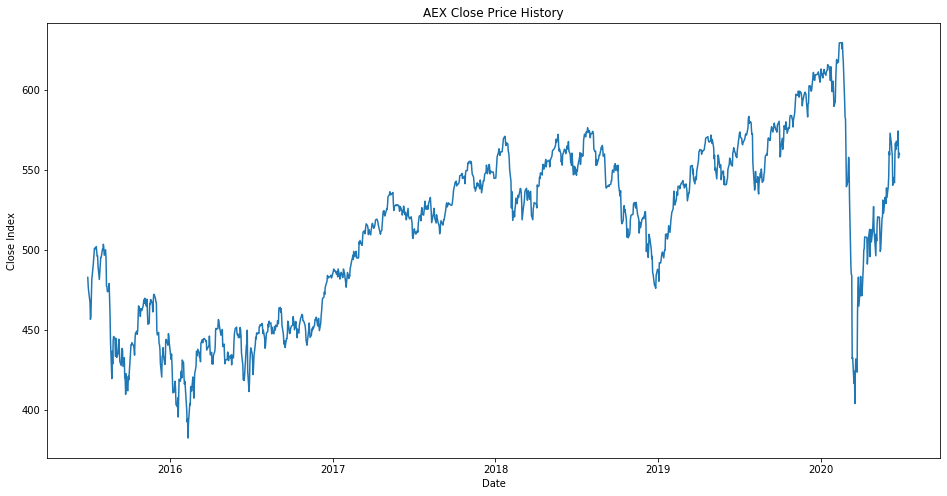

In [187]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title('AEX Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Index')
plt.show()

In [97]:
'''Split a part of the dataset into train and test set'''

# Create a new data frame with only 'Close' column
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

1022

First the value needs to be normalized in order to see which aspects were the most influential. In de praktijk is het bijna nooit mogelijk om data in een neural network te gooien zonder het eerst te preprocessen

In [98]:
'''Scale the data'''
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.40637418],
       [0.38257238],
       [0.37113778],
       ...,
       [0.70845836],
       [0.72094721],
       [0.71855486]])

De data moet gereshaped worden omdat het LSTM netwerk verwacht dat er een 3D dataset wordt ingegeven.

In [99]:
'''Create Training set'''
# Create scaled training dataset'
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train
x_train, y_train = [], []

# Create a dataset of the desired amount of days used to predict the next day
history_days = 60
for i in range(history_days, len(train_data)):
    x_train.append(train_data[i-history_days:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)

# Convert training arrays to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
features = 1

x_train = np.reshape(x_train, (x_train.shape[0], history_days, features))
x_train.shape

[array([0.40637418, 0.38257238, 0.37113778, 0.34320006, 0.30017841,
       0.30990998, 0.35422918, 0.40053524, 0.43504176, 0.45101776,
       0.46435812, 0.48009083, 0.47773903, 0.48442949, 0.47096748,
       0.46026275, 0.46119536, 0.43560944, 0.40106236, 0.41829535,
       0.43256832, 0.45641067, 0.45665396, 0.47773903, 0.47607656,
       0.49010624, 0.48098289, 0.46224961, 0.47615765, 0.45312627,
       0.3844376 , 0.38269402, 0.37012408, 0.37178655, 0.39088476,
       0.35126916, 0.31043711, 0.24434352, 0.15031222, 0.21924418,
       0.18700835, 0.24633039, 0.25687292, 0.25310194, 0.20647149,
       0.20659314, 0.25115562, 0.20407915, 0.21445949, 0.23059768,
       0.24997973, 0.21733842, 0.19309058, 0.18356175, 0.20087584,
       0.22662396, 0.22309626, 0.18129106, 0.20351148, 0.15152867])]
[0.1480415213689077]


(962, 60, 1)

In [100]:
'''Build the LSTM Sequential Model'''

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(history_days, features)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [101]:
'''Compile and train the model'''

# Compile Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train Model
model.fit(x_train, y_train, batch_size=1, epochs=1)

962/962 [==============================] - 14s 15ms/step - loss: 0.0039


In [102]:
'''Create test dataset'''

# Create new array containing scaled values from last indices
test_data = scaled_data[training_data_len-history_days: , :]

# Create datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert test set to numpy array
x_test = np.array(x_test)

# Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], features))

In [103]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [104]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

8.831850739123771

/home/denny/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


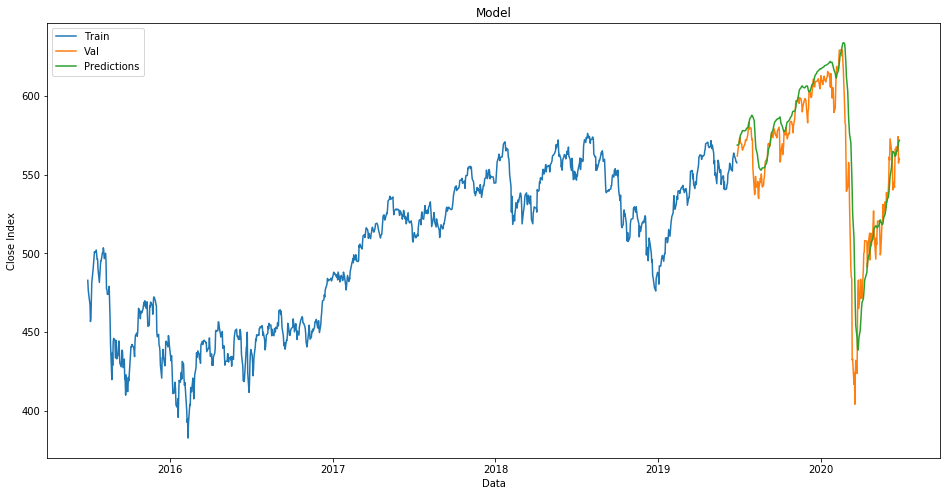

In [105]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Data')
plt.ylabel('Close Index')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()

In [226]:
'''Test if profit would have been made over the testing results'''

pred_list = np.array(valid['Predictions'])
real_list = np.array(valid['Close'])

min_confidence = 0.999
reward_list = []
reward = 1000
it = 0
real_value = real_list[0]

for i in range(1, len(pred_list)-1):
    if pred_list[i] * min_confidence > real_value:
        reward = reward + reward * ((real_list[i] - real_value)/real_value)
        reward_list.append(reward)
        it += 1
    elif pred_list[i] < real_value * min_confidence:
        reward = reward + reward * ((real_value - real_list[i])/real_value)
        it += 1
        reward_list.append(reward)
    real_value = real_list[i]

print(len(reward_list))    
    
print('Total profit = {}'.format(reward))
print('Total amount of investments = {}'. format(it))

241
Total profit = 947.0496805071361
Total amount of investments = 241


In [186]:
'''Example of predicting a single day'''

# Create new df
new_df = df.filter(['Close'])
print(new_df[-61:-1])


# Get the last 60 day closing index values and convert the dataframe to an array
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list
X_test = []

# Append past 60 days
X_test.append(last_60_days_scaled)

# Convert X_test dataset to numpy array
X_test = np.array(X_test)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get predicted scaled price
pred_price = model.predict(X_test)
print(pred_price)

             Close
Date              
2020-03-31  483.44
2020-04-01  471.30
2020-04-02  478.28
2020-04-03  471.46
2020-04-06  489.82
2020-04-07  499.85
2020-04-08  500.71
2020-04-09  508.04
2020-04-14  507.74
2020-04-15  491.13
2020-04-16  496.08
2020-04-17  505.82
2020-04-20  512.76
2020-04-21  495.76
2020-04-22  509.62
2020-04-23  512.73
2020-04-24  504.94
2020-04-27  512.19
2020-04-28  519.97
2020-04-29  526.96
2020-04-30  512.92
2020-05-04  496.31
2020-05-05  509.83
2020-05-06  505.55
2020-05-07  516.26
2020-05-08  520.57
2020-05-11  520.33
2020-05-12  520.44
2020-05-13  512.19
2020-05-14  499.03
2020-05-15  500.31
2020-05-18  519.89
2020-05-19  520.45
2020-05-20  531.06
2020-05-21  522.81
2020-05-22  524.38
2020-05-25  532.82
2020-05-26  531.30
2020-05-27  528.96
2020-05-28  538.62
2020-05-29  532.57
2020-06-01  539.54
2020-06-02  546.12
2020-06-03  561.30
2020-06-04  559.13
2020-06-05  572.80
2020-06-08  566.20
2020-06-09  561.75
2020-06-10  559.28
2020-06-11  540.26
2020-06-12  